In [145]:
import pandas as pd
import numpy as np

# for EDA
import matplotlib
from matplotlib import pylab as plt
import seaborn as sns

#for split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

# for proprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


In [121]:
df = pd.read_csv('/Users/chujunchen/Desktop/DATA1030-Pony/Final Project/PS_20174392719_1491204439457_log.csv')
# given 1 step is 1 hour, we want to have 7 days, step = 168
df = df[df['step'] <= 168]
df = df.drop(columns=['isFlaggedFraud'])
# make sure nameOrig is unique

In [122]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [123]:
df.shape

(1930180, 10)

In [124]:
# Check uniqueness for 'nameOrig'
is_nameOrig_unique = df['nameOrig'].nunique() == len(df)

# Check uniqueness for 'nameDest'
is_nameDest_unique = df['nameDest'].nunique() == len(df)

print(f"Are all values in 'nameOrig' unique? {is_nameOrig_unique}")
print(f"Are all values in 'nameDest' unique? {is_nameDest_unique}")

Are all values in 'nameOrig' unique? False
Are all values in 'nameDest' unique? False


In [125]:
with pd.option_context('display.max_rows', None):
    print((df.dtypes))

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
dtype: object


In [65]:
# EDA

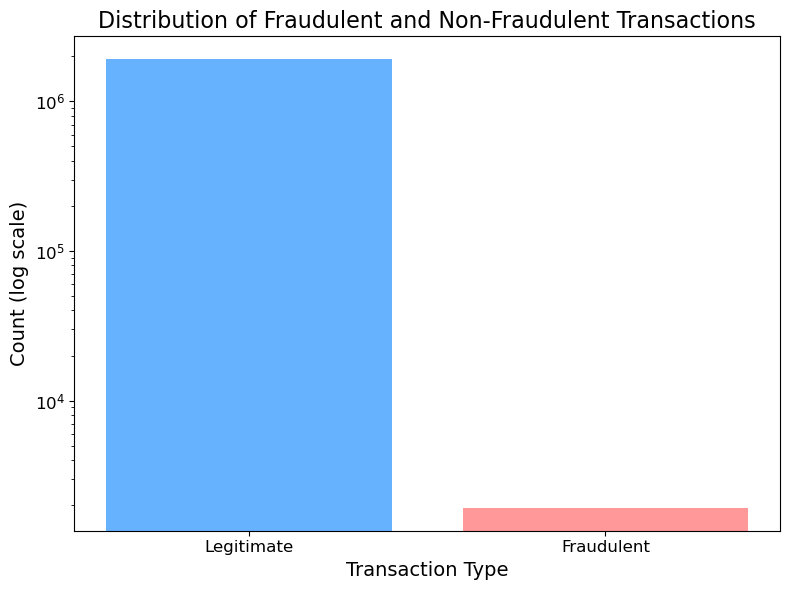

In [183]:
# Extracting the counts
counts = df['isFraud'].value_counts()

# Labels based on unique values in 'isFraud'
labels = ['Legitimate' if not i else 'Fraudulent' for i in counts.index]
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['#66b2ff', '#ff9999']  # Light blue for 'Not Fraud' and light red for 'Fraud'
ax.bar(labels, counts, color=colors)

# Set the scale of y-axis to logarithmic so the fraud cases are visible
ax.set_yscale('log')

# Add title and labels
ax.set_title('Distribution of Fraudulent and Non-Fraudulent Transactions', fontsize = 16)
ax.set_ylabel('Count (log scale)', fontsize = 14)
ax.set_xlabel('Transaction Type', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


#If the coefficient is high: it is a good idea to remove all but one of the strongly correlated features. This will have no impact on your model's performance, but may speed-up its convergence time. In this case: I plan to use the difference?

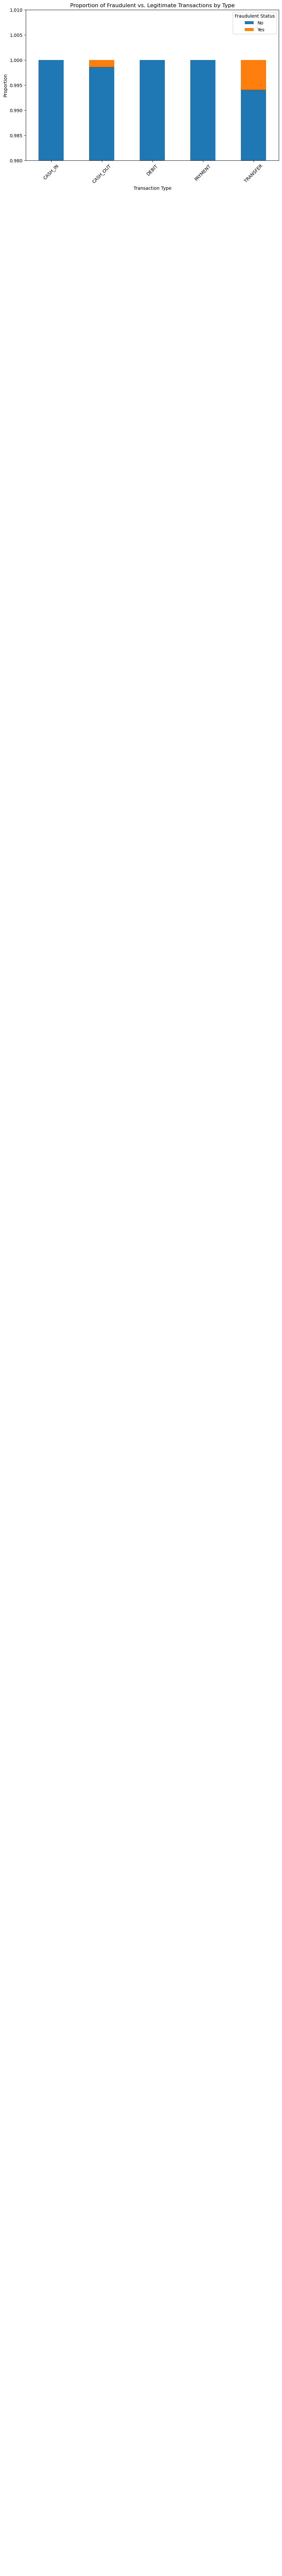

In [96]:
# Using previous code to get fraud_proportions
fraud_counts = df.groupby(['type', 'isFraud']).size().unstack()
fraud_proportions = fraud_counts.div(fraud_counts.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
ax = fraud_proportions.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Proportion of Fraudulent vs. Legitimate Transactions by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.ylim([0.98, 1.01])
plt.legend(title='Fraudulent Status', loc='upper right', labels=['No', 'Yes'])

# Adjusting annotations:
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0.001:  # Adjust condition as per your dataset
        ax.text(x+width/2, 
                y+height/2, 
                f"{height:.4f}", 
                ha='center', 
                va='center', 
                fontsize=10, 
                color='black' if height < 0.02 else 'white')  # Adjust font color based on height
    plt.show()

In [ ]:
# balance diff(in recipent): 

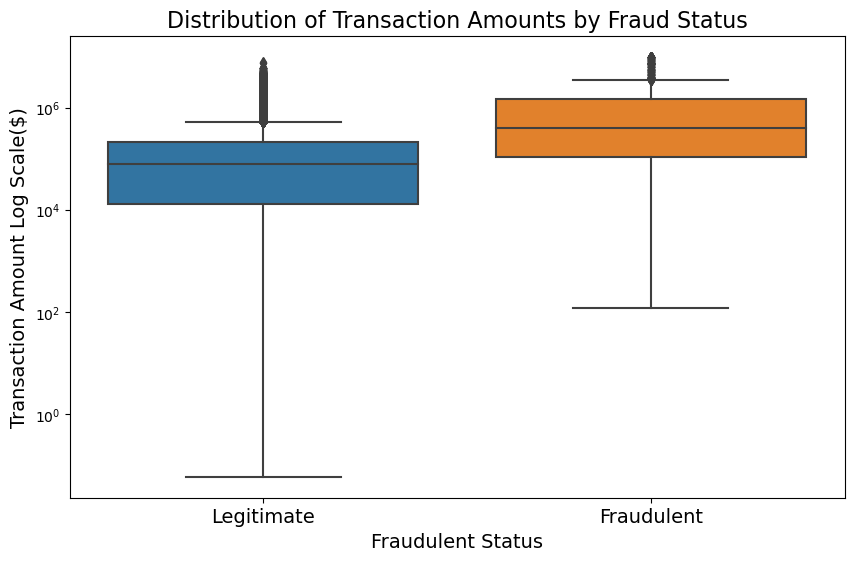

In [187]:
# amount and Fraud
# Drawing the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='isFraud', y='amount', data=df)

# Setting labels and title
plt.title('Distribution of Transaction Amounts by Fraud Status', fontsize = 16)
plt.xlabel('Fraudulent Status', fontsize = 14)
plt.ylabel('Transaction Amount Log Scale($)', fontsize = 14)
plt.yscale('log')
plt.xticks([0, 1], ['Legitimate', 'Fraudulent'], fontsize = 14)  # Assuming isFraud has values 0 and 1

plt.show()


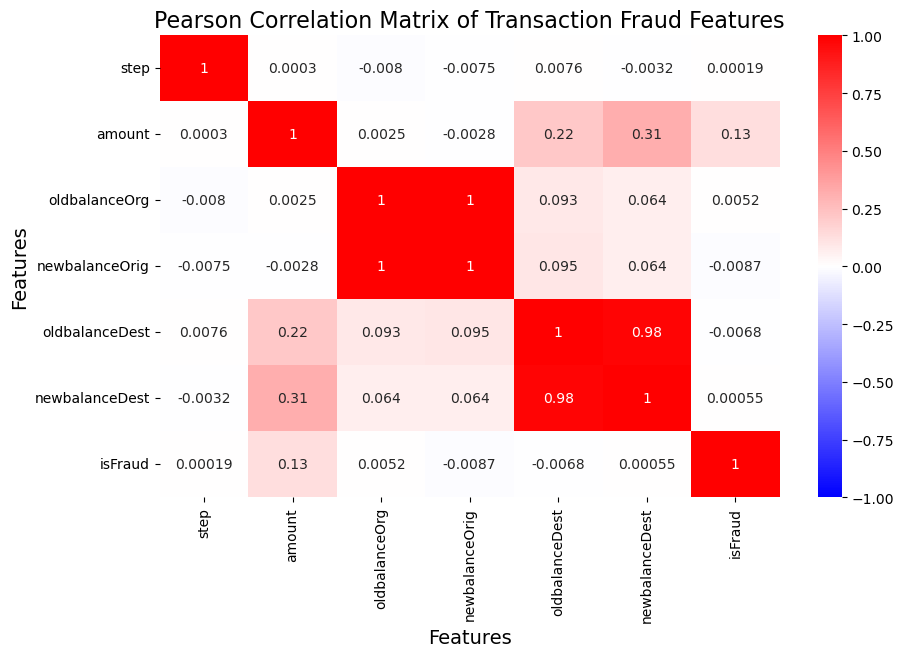

In [188]:
# Correlation matrix focus only Transfer and Cash out transaction types, as they have been identified as fraud.

correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='bwr', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix of Transaction Fraud Features', fontsize = 16)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Features', fontsize = 14)
plt.show()

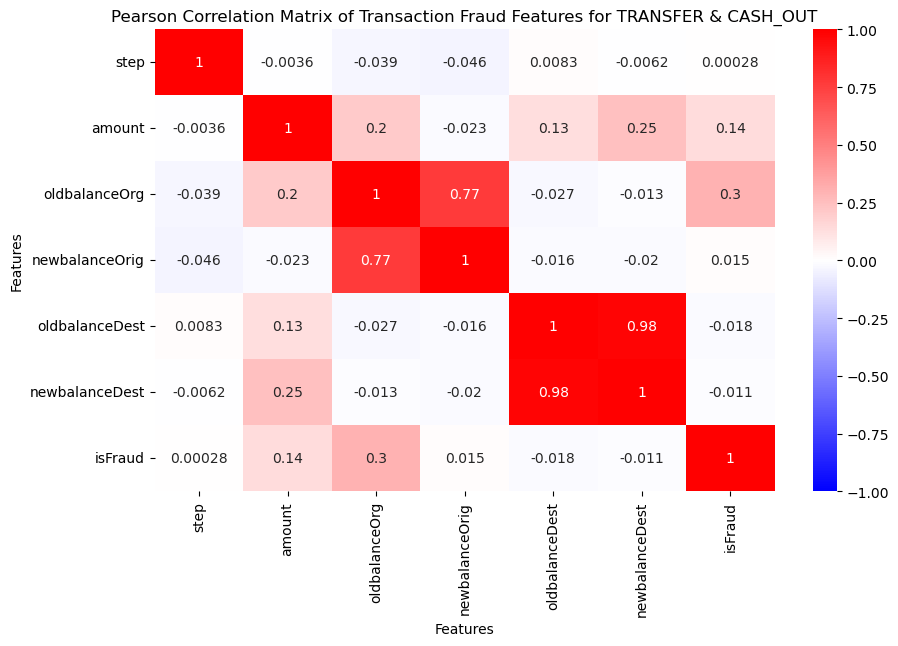

In [99]:
# Filter the dataframe to only include "TRANSFER" and "CASH_OUT" transaction types
df_filtered = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

# Compute the correlation matrix only for numeric columns
correlation_matrix = df_filtered.select_dtypes(include=['float64', 'int64']).corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='bwr', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix of Transaction Fraud Features for TRANSFER & CASH_OUT')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

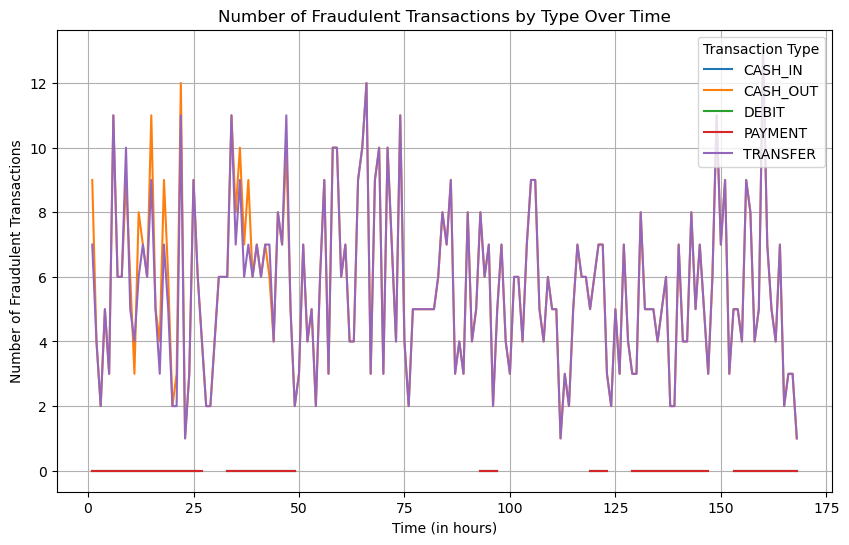

In [126]:
# Pivot table to see frauds for each transaction type over time
fraud_by_type_over_time = df.pivot_table(index='step', columns='type', values='isFraud', aggfunc='sum')

plt.figure(figsize=(10,6))
fraud_by_type_over_time.plot(ax=plt.gca())
plt.title('Number of Fraudulent Transactions by Type Over Time')
plt.xlabel('Time (in hours)')
plt.ylabel('Number of Fraudulent Transactions')
plt.grid(True)
plt.legend(title='Transaction Type')
plt.show()


 account associated with each transcation; check in the historical data, what you know about the recipients ; create a database of unique recipients and unique customers: how much money, type; cretea new feature to help it more accurate. Do a mimimum; focus on property of transaction as the historical datase; 

In [128]:
# Data Cleaning
X = df.copy()

# Drop columns 'nameOrig', 'nameDest', and 'oldbalanceDest'
X = X.drop(['nameOrig', 'nameDest', 'oldbalanceDest'], axis = 1)

# Separate the target variable
y = X['isFraud']
del X['isFraud']

print(y.value_counts())
# make sure train, test, val

isFraud
0    1928276
1       1904
Name: count, dtype: int64


In [142]:
# keep the time series ordered while spliting;
# the most recent as test; middle as the val; older
# Initialize TimeSeriesSplit
# To ensure the test set, which is the 5th portion, being 20% of the data
tscv = TimeSeriesSplit(n_splits=4)

# Using TimeSeriesSplit to extract the last split
for _, (train_val_indices, test_indices) in enumerate(tscv.split(X)):
    pass  # We're using this loop to get the final split indices

# Extract training + validation set and test set
X_train_val, X_test = X.iloc[train_val_indices], X.iloc[test_indices]
y_train_val, y_test = y.iloc[train_val_indices], y.iloc[test_indices]

# Further split the training + validation set to achieve 60-20-20 split
train_size = int(0.75 * len(X_train_val))

X_train, X_val = X_train_val[:train_size], X_train_val[train_size:]
y_train, y_val = y_train_val[:train_size], y_train_val[train_size:]

# Verify the splits
print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Print the head of the data
print("Train set head:")
print(X_train.head())

print("\nValidation set head:")
print(X_val.head())

print("\nTest set head:")
print(X_test.head())

Train set size: 1158108
Validation set size: 386036
Test set size: 386036
Train set head:
   step      type    amount  oldbalanceOrg  newbalanceOrig  newbalanceDest
0     1   PAYMENT   9839.64       170136.0       160296.36             0.0
1     1   PAYMENT   1864.28        21249.0        19384.72             0.0
2     1  TRANSFER    181.00          181.0            0.00             0.0
3     1  CASH_OUT    181.00          181.0            0.00             0.0
4     1   PAYMENT  11668.14        41554.0        29885.86             0.0

Validation set head:
         step      type     amount  oldbalanceOrg  newbalanceOrig  \
1158108   131  CASH_OUT  139763.68          249.0            0.00   
1158109   131     DEBIT   20265.71          316.0            0.00   
1158110   131  CASH_OUT   28414.44          822.0            0.00   
1158111   131   PAYMENT   43224.52            0.0            0.00   
1158112   131   PAYMENT    8371.34       107288.0        98916.66   

         newbalanceDest

In [152]:
# Before preprocessing
print("Before preprocessing:")
print(f"Training set: {X_train.shape[0]} data points, {X_train.shape[1]} features")
print(f"Validation set: {X_val.shape[0]} data points, {X_val.shape[1]} features")
print(f"Test set: {X_test.shape[0]} data points, {X_test.shape[1]} features")

Before preprocessing:
Training set: 1158108 data points, 6 features
Validation set: 386036 data points, 6 features
Test set: 386036 data points, 6 features


In [170]:
# Preprocessing Pipeline

# Given your columns
cat_ftrs = ['type']
num_ftrs = ['amount']

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

# Numeric transformer
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)], remainder='passthrough')

In [168]:
# Fit and transform the training set
X_prep_train = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()
df_train = pd.DataFrame(data=X_prep_train, columns=feature_names)

# Transform the validation set (X_val)
X_prep_val = preprocessor.transform(X_val)
df_val = pd.DataFrame(data=X_prep_val, columns=feature_names)

# Transform the test set
X_prep_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=X_prep_test, columns=feature_names)

/Users/chujunchen/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [169]:
# After preprocessing
print("\nAfter preprocessing:")
print(f"Training set: {df_train.shape[0]} data points, {df_train.shape[1]} features")
print(f"Validation set: {df_val.shape[0]} data points, {df_val.shape[1]} features")
print(f"Test set: {df_test.shape[0]} data points, {df_test.shape[1]} features")


After preprocessing:
Training set: 1158108 data points, 10 features
Validation set: 386036 data points, 10 features
Test set: 386036 data points, 10 features


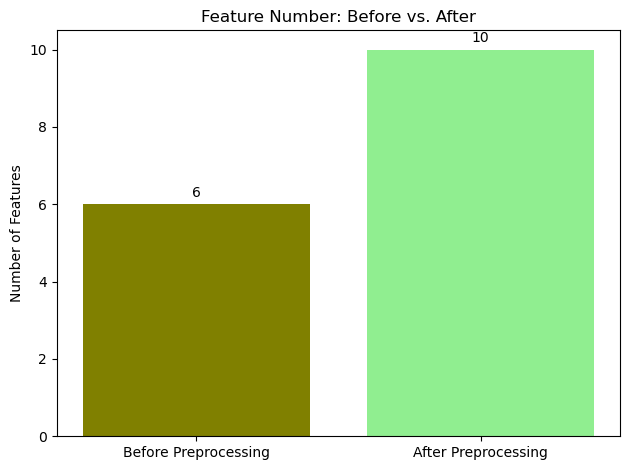

In [176]:
# Given data
features_before = 6
features_after = 10

# Bar chart data
labels = ['Before Preprocessing', 'After Preprocessing']
features = [features_before, features_after]

# Create the bar chart
fig, ax = plt.subplots()
bars = ax.bar(labels, features, color=['olive', 'lightgreen'])

# Annotate with the number of features
for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Add title and labels
ax.set_title("Feature Number: Before vs. After")
ax.set_ylabel("Number of Features")

# Show the plot
plt.tight_layout()
plt.show()
